In [1]:
from database import *

def ticks_to_kbars(ticks, interval='5Min'):

    kbars = pd.DataFrame()
    
    kbars['open'] = ticks['close'].resample(interval).first()
    kbars['close'] = ticks['close'].resample(interval).last()
    kbars['high'] = ticks['close'].resample(interval).max()
    kbars['low'] = ticks['close'].resample(interval).min()
    kbars['volume'] = ticks['volume'].resample(interval).sum()
    
    kbars.dropna(inplace=True)
    
    return kbars

In [2]:
import talib

def get_technical_indicator(kbars):
    
    kbars['rsi'] = talib.RSI(kbars.close, timeperiod=14)
    kbars['cci'] = talib.CCI(kbars.high, kbars.low, kbars.close, timeperiod=14)
    
    macd, macdsignal, macdhist = talib.MACD(kbars.close, fastperiod=5, slowperiod=34, signalperiod=5)
    
    kbars['macd'] = macd
    kbars['macdsignal'] = macdsignal
    kbars['macdhist'] = macdhist
    
        
    kbars['slowk'], kbars['slowd'] = talib.STOCH(kbars.high,
                        kbars.low,
                        kbars.close,
                        fastk_period=9,
                        slowk_period=3,
                        slowk_matype=0,
                        slowd_period=3,
                        slowd_matype=0)

    upper, middle, lower = talib.BBANDS(kbars.close, 
                                        timeperiod=20, 
                                        nbdevup=2.1, 
                                        nbdevdn=2.1, 
                                        # Moving average type: simple moving average here
                                        matype=0)
    kbars['upper'] = upper
    kbars['middle'] = middle
    kbars['lower'] = lower
    
    return kbars

In [3]:
def day_trading_backtest(code, date, connection, api):
    
    tw_calendar = get_calendar('XTAI')
    prev_trading_date = tw_calendar.previous_close(date).date()
    
    ticks = get_ticks(code, prev_trading_date, connection, api)[0].append(get_ticks(code, date, connection, api)[0])
    kbars = ticks_to_kbars(ticks, '5Min')
    if kbars.empty:
        return pd.DataFrame()
    kbars = get_technical_indicator(kbars)
    prev_close_price = kbars['close'].get(pd.to_datetime(prev_trading_date).replace(hour=13, minute=30))
    kbars = kbars[date:]
    
    entry_price = 0
    entry_time = None
    
    exit_price = 0
    exit_time = None
    
    position = 0
    open_price = 0
            
    for ts in range(len(kbars)):
#         current_time = kbars.iloc[ts].name + pd.Timedelta(minutes=5)
        current_time = kbars.iloc[ts].name
        current_price = kbars['open'][ts]
        if ts == 0: 
            open_price = kbars['open'][ts]
            continue
        if ts ==1:
            if(kbars['close'][0] >= open_price * 1.04):
                break
#             continue
        
        if (
            position == 0 and
            current_time <= date.replace(hour=10, minute=30, second=0) and
            kbars.iloc[ts-1]['cci'] < -350 and
            kbars.iloc[ts-1]['lower'] > current_price
#             kbars.iloc[ts-1]['cci'] < -100 and
#             kbars.iloc[ts-1]['slowk'] < 10 and
#             kbars.iloc[ts-1]['rsi'] < 30
        ):
            if current_price < 20:
                position = 20
            else:
                position = 2          
            entry_price = current_price
            entry_time = current_time.time()

            print('[{}] buy {} at {}'.format(current_time, code, current_price))
        
        elif (
            position != 0 and
            ((current_price >= entry_price * 1.03) or
            (current_price <= entry_price * 0.98) or
            (current_price > entry_price and kbars.iloc[ts-1]['slowk'] > 70) or
            (current_price > entry_price and kbars.iloc[ts-1]['rsi'] > 70) or
            (current_price >= entry_price * 1.01 and kbars.iloc[ts-1]['cci'] < -60) or
            (current_price > entry_price and kbars.iloc[ts-1]['cci'] > 200) or
            (current_price > entry_price and kbars.iloc[ts-1]['upper'] < current_price))
        ):
            exit_price = current_price
            exit_time = current_time.time()
            print('[{}] sell {} at {}'.format(current_time, code, current_price))
            
            break
            
        elif (
            current_time >= date.replace(hour=13, minute=20, second=0) and
            position != 0
        ):
            
            exit_price = current_price
            exit_time = current_time.time()
            
            print('[{}] sell {} at {}'.format(current_time, code, current_price))
            
            break
            
    if entry_time and exit_time:
        transaction = pd.DataFrame([[date, 
                                     code, 
                                     entry_time,
                                     entry_price, 
                                     position * 1000,
                                     entry_price * position * 1000,
                                     exit_time,
                                     exit_price,
                                     position * 1000,
                                     exit_price * position * 1000]
                                   ],
                                    columns=[
                                        '成交日期', 
                                        '股票代號',
                                        '買進時間',
                                        '買進價格',
                                        '買進股數',
                                        '買進金額',
                                        '賣出時間',
                                        '賣出價格',
                                        '賣出股數',
                                        '賣出金額'])
        return transaction
    else:
        return pd.DataFrame()

In [4]:
import json

with open('config.json') as f:
  config = json.load(f)

api = sj.Shioaji()
api.login(
    person_id = config['account'],
    passwd= config['password'],
    contracts_cb=lambda security_type: print(f"{repr(security_type)} fetch done."))

# api.logout()

connection = sqlite3.connect('data.db')

Response Code: 0 | Event Code: 0 | Info: host '203.66.91.161:80', hostname '203.66.91.161:80' IP 203.66.91.161:80 (host 1 of 1) (host connection attempt 1 of 1) (total connection attempt 1 of 1) | Event: Session up
<SecurityType.Index: 'IND'> fetch done.


In [5]:
def get_trading_codes(codes, connection, api):
    trading_codes = []
    for code in codes:
        stock = get_stock(code, connection, api)
        if not stock[0].empty and stock[0].iloc[0]['day_trade'] == 'Yes':
            trading_codes.append(code)
    return trading_codes

In [6]:
def backtest(start_date, end_date, connection, api, discount=0.38):
    
    tw_calendar = get_calendar('XTAI')
    
    transactions = pd.DataFrame()
    update_daily_prices(start_date, end_date, connection)
    for date in pd.date_range(start_date, end_date):

        if date not in tw_calendar.opens:
            continue
        
        codes = get_stocks(date, connection)

#         day_trading_codes = [code for code in codes if get_stock(code, connection, api)[0].iloc[0]['day_trade'] == 'Yes']
        day_trading_codes = get_trading_codes(codes, connection, api)
        for code in day_trading_codes:
            
            transaction = day_trading_backtest(code, pd.to_datetime(date), connection, api)
            
            if not transaction.empty:
                transactions = transactions.append(transaction)
                
    if not transactions.empty:

        transactions['買進手續費'] = transactions['買進金額'] * 0.001425 * discount
        transactions['買進手續費'] = transactions['買進手續費'].apply(lambda fee : fee if fee > 20 else 20)
        transactions['買進手續費'] = transactions['買進手續費'].astype(int)

        transactions['賣出手續費'] = transactions['賣出金額'] * 0.001425 * discount
        transactions['賣出手續費'] = transactions['賣出手續費'].apply(lambda fee : fee if fee > 20 else 20)
        transactions['賣出手續費'] = transactions['賣出手續費'].astype(int)

        transactions['交易稅'] = transactions['賣出金額'] * 0.0015
        transactions['交易稅'] = transactions['交易稅'].astype(int)

        transactions['損益'] = (transactions['賣出金額'] - transactions['買進金額']) - (transactions['買進手續費'] + transactions['賣出手續費'] + transactions['交易稅'])

        transactions = transactions.set_index(['成交日期'])
        
    return transactions

In [7]:
transactions = backtest('2021/1/1', '2021/4/27', connection, api)
transactions 

<SecurityType.Future: 'FUT'> fetch done.
<SecurityType.Stock: 'STK'> fetch done.
<SecurityType.Option: 'OPT'> fetch done.
20210208 找不到資料
20210209 找不到資料
20210402 找不到資料
[2021-01-08 09:05:00] buy 1314 at 11.15
[2021-01-08 10:10:00] sell 1314 at 10.9
[2021-01-12 09:05:00] buy 1597 at 99.3
[2021-01-12 10:40:00] sell 1597 at 99.4
[2021-01-26 09:05:00] buy 2375 at 104.5
[2021-01-26 09:50:00] sell 2375 at 102.0
[2021-01-28 09:05:00] buy 2375 at 98.2
[2021-01-28 09:10:00] sell 2375 at 100.0
[2021-02-26 09:05:00] buy 2611 at 10.1
[2021-02-26 09:25:00] sell 2611 at 10.3
[2021-04-07 09:05:00] buy 5471 at 112.5
[2021-04-07 09:55:00] sell 5471 at 110.0
[2021-04-12 09:05:00] buy 1515 at 99.0
[2021-04-12 09:20:00] sell 1515 at 101.0
[2021-04-20 09:10:00] buy 2305 at 10.25
[2021-04-20 09:15:00] sell 2305 at 10.4


,股票代號,買進時間,買進價格,買進股數,買進金額,賣出時間,賣出價格,賣出股數,賣出金額,買進手續費,賣出手續費,交易稅,損益
成交日期,,,,,,,,,,,,,
2021-01-08,1314,09:05:00,11.15,20000,223000.0,10:10:00,10.9,20000,218000.0,120,118,327,-5565.0
2021-01-12,1597,09:05:00,99.30,2000,198600.0,10:40:00,99.4,2000,198800.0,107,107,298,-312.0
2021-01-26,2375,09:05:00,104.50,2000,209000.0,09:50:00,102.0,2000,204000.0,113,110,306,-5529.0
2021-01-28,2375,09:05:00,98.20,2000,196400.0,09:10:00,100.0,2000,200000.0,106,108,300,3086.0
2021-02-26,2611,09:05:00,10.10,20000,202000.0,09:25:00,10.3,20000,206000.0,109,111,309,3471.0
2021-04-07,5471,09:05:00,112.50,2000,225000.0,09:55:00,110.0,2000,220000.0,121,119,330,-5570.0
2021-04-12,1515,09:05:00,99.00,2000,198000.0,09:20:00,101.0,2000,202000.0,107,109,303,3481.0
2021-04-20,2305,09:10:00,10.25,20000,205000.0,09:15:00,10.4,20000,208000.0,111,112,312,2465.0


In [8]:
daily_profit_loss = transactions.resample('D').sum()
daily_profit_loss['交易次數'] = transactions.groupby('成交日期').size()
daily_profit_loss = daily_profit_loss[['買進金額', '買進手續費', '賣出金額', '賣出手續費', '交易稅', '損益', '交易次數']]
daily_profit_loss.dropna(inplace=True) 

daily_profit_loss

,買進金額,買進手續費,賣出金額,賣出手續費,交易稅,損益,交易次數
成交日期,,,,,,,
2021-01-08,223000.0,120,218000.0,118,327,-5565.0,1.0
2021-01-12,198600.0,107,198800.0,107,298,-312.0,1.0
2021-01-26,209000.0,113,204000.0,110,306,-5529.0,1.0
2021-01-28,196400.0,106,200000.0,108,300,3086.0,1.0
2021-02-26,202000.0,109,206000.0,111,309,3471.0,1.0
2021-04-07,225000.0,121,220000.0,119,330,-5570.0,1.0
2021-04-12,198000.0,107,202000.0,109,303,3481.0,1.0
2021-04-20,205000.0,111,208000.0,112,312,2465.0,1.0


In [9]:
monthly_profit_loss = daily_profit_loss.resample('M').sum()
monthly_profit_loss 

,買進金額,買進手續費,賣出金額,賣出手續費,交易稅,損益,交易次數
成交日期,,,,,,,
2021-01-31,827000.0,446,820800.0,443,1231,-8320.0,4.0
2021-02-28,202000.0,109,206000.0,111,309,3471.0,1.0
2021-03-31,0.0,0,0.0,0,0,0.0,0.0
2021-04-30,628000.0,339,630000.0,340,945,376.0,3.0


In [10]:
# 總損益
profit_loss = daily_profit_loss['損益'].sum()
profit_loss

-4473.0

In [11]:
# 勝率
win_rate = round(len(transactions[transactions['損益'] > 0]) / len(transactions), 3)
win_rate

0.5

In [12]:
# 最大連續虧損
con_loss = 0
max_loss = 0

for profit_loss in daily_profit_loss["損益"]:
    
    if profit_loss < 0:
        con_loss += profit_loss
    else:
        con_loss = 0
        continue
    
    if con_loss < max_loss:
        max_loss = con_loss
        
print('最大連續虧損', max_loss)

最大連續虧損 -11406.0


[Text(0.5, 0, 'profit loss')]

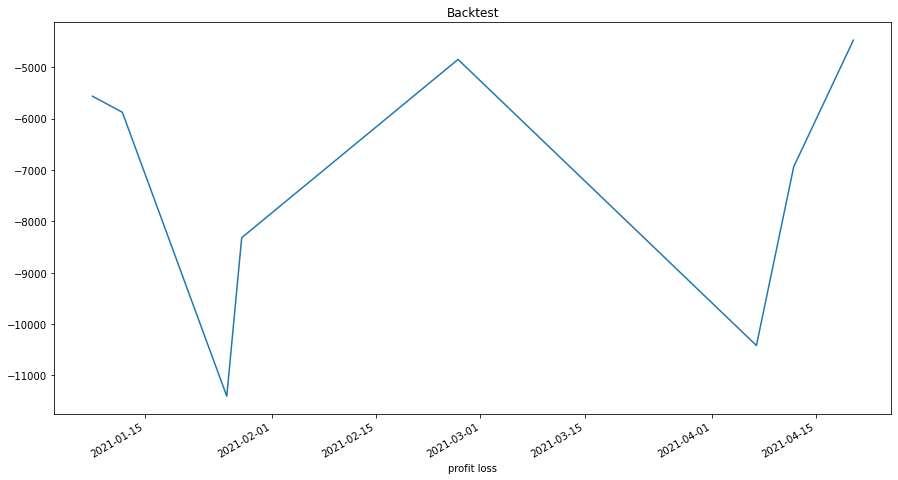

In [13]:
daily_profit_loss['損益'].cumsum()
daily_profit_loss['損益'].cumsum().plot(title='Backtest', figsize=(15, 8)).set(xlabel='profit loss')